# import

In [1]:
import os
import sys
import glob
import math
import itertools
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from config import *

sys.path.append(os.path.normpath('../../src'))
from drift_induction import DRIFT_INDUCTION
from util import fix_plot

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sansmath}\n\\sansmath'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [4]:
SAVE_TO_FILE = False
SAVE_EXT = '.eps'

# Make synthetic drift

In [5]:
def make_dataset(dataset):
    path = os.path.join(INTERIM_DATA_DIR, dataset + '_' + BASE_DATA_TYPE + '.csv')
    di = DRIFT_INDUCTION(dataset, path, DRIFT_INFO_DIR)

    # base condition
    seed = 0
    change_point = 0.5
    shuffle_ratio = 0.2
    how_feature = 'relevant'
    how_class = 'all'

    # loop variables
    seed_list = DATA_PRMS['seed']
    how_feature_list = DATA_PRMS['how_feature']
    how_class_list = DATA_PRMS['how_class']

    itr = itertools.product(seed_list, how_feature_list, how_class_list)
    for i, (seed, how_feature, how_class) in enumerate(itr):

        data_cond = {
            'seed': seed,
            'change_point': change_point,
            'shuffle_ratio': shuffle_ratio,
            'how_feature': how_feature,
            'how_class': how_class,
        }

        di.induct(**data_cond)

for dataset in All_DATASETS:
    make_dataset(dataset)

# Select valid datasets

In [6]:
def agg_metadata(datasets):
    data_conds = list()
    metadatas = list()
    for dataset in datasets:
        info_list = glob.glob(os.path.join(DRIFT_INFO_DIR, dataset, '*'))
        for info in info_list:
            data_cond, metadata, idx_col = DRIFT_INDUCTION.load(info)
            data_conds.append(data_cond)
            metadatas.append(metadata)

    df_dc = pd.DataFrame(data_conds)
    df_meta = pd.DataFrame(metadatas)
    df_meta = pd.concat([df_dc, df_meta], axis=1)
    df_meta = df_meta[df_meta['how_class'] == 'minor']
    return df_meta

df_meta = agg_metadata(All_DATASETS)

In [7]:
def select_valid_datasets(df_meta, min_score=0.5, max_irr_drop=0.01, min_rel_drop=0.05):
    df_tmp = df_meta[['dataset', 'how_feature', 'prev_score', 'post_score']].copy()
    df_tmp['change_in_score'] = df_tmp['post_score'] - df_tmp['prev_score']
    df_tmp = df_tmp.groupby(['dataset', 'how_feature']).mean().unstack(level=1)
    df_tmp = df_tmp.T[All_DATASETS].T
    df_tmp = df_tmp[df_tmp['prev_score']['irrelevant'] > min_score]
    df_tmp = df_tmp[abs(df_tmp['change_in_score']['irrelevant']) < max_irr_drop]
    df_tmp = df_tmp[df_tmp['change_in_score']['relevant'] < -min_rel_drop]
    df_tmp = df_tmp.reset_index()
    return df_tmp

df_tmp = select_valid_datasets(df_meta)
selected_datasets = df_tmp['dataset'].values.tolist()
with open('dataset.conf', 'w') as f:
    json.dump({'selected_datasets': selected_datasets}, f, indent=2)
df_tmp

dataset prev_score           post_score            \
how_feature                     irrelevant  relevant irrelevant  relevant   
0                  Anuran_Calls   0.927673  0.927673   0.927380  0.364356   
1                         avila   0.789030  0.789030   0.791358  0.338566   
2              Cardiotocography   0.734804  0.734804   0.734280  0.293713   
3                           EEG   0.566234  0.566234   0.567052  0.460359   
4                         image   0.892764  0.892764   0.892975  0.492260   
5                       landsat   0.740234  0.740234   0.741623  0.637668   
6            letter-recognition   0.748604  0.748604   0.750994  0.383639   
7                         magic   0.665408  0.665408   0.665354  0.577619   
8                   page-blocks   0.777697  0.777697   0.776964  0.562298   
9                     pendigits   0.933011  0.933011   0.932803  0.350575   
10               Wall-following   0.870287  0.870287   0.872341  0.343904   

            change_in_score            
how_feature      irrelevant  relevant  
0                 -0.000293 -0.563318  
1                  0.002328 -0.450464  
2                 -0.000524 -0.441091  
3                  0.000818 -0.105875  
4                  0.000211 -0.400504  
5                  0.001388 -0.102566  
6                  0.002391 -0.364965  
7                 -0.000053 -0.087789  
8                 -0.000733 -0.215399  
9                 -0.000208 -0.582436  
10                 0.002054 -0.526383

# Check induction effect

In [8]:
def plot_drift_magnitude(df_meta, datasets):
    df_plt = df_meta[['dataset', 'how_feature', 'prev_hd', 'post_hd']].copy()
    df_plt['without drift'] = df_meta['prev_hd'].apply(lambda x: np.mean(x)).values
    df_plt['with drift'] = df_meta['post_hd'].apply(lambda x: np.mean(x)).values
    m = df_plt.groupby(['dataset', 'how_feature']).mean()
    s = df_plt.groupby(['dataset', 'how_feature']).std()

    ncols = 6
    nrows = math.ceil(len(datasets) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*1.5, nrows*1.5), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, d in enumerate(datasets):
        ax = axes[i]
        m.loc[d].plot.bar(yerr=s.loc[d], ax=ax)
        ax.set_ylim(0, 0.11)
        ax.set_xlabel('')
        ax.set_ylabel('drift magnitude')
        ax.tick_params(axis='x', labelrotation=0)
        ax.legend([], frameon=False)
        ax.tick_params(axis='y', direction='in')
        ax.text(0.98, 0.98, d.replace('_', '-'), horizontalalignment='right', verticalalignment='top',
                transform=ax.transAxes)

        if (i // ncols) < (nrows - 1):
            ax.xaxis.set_visible(False)
#         if (i % ncols) > 0:
#             ax.yaxis.set_visible(False)

    (m.loc[d] * 0).plot.bar(ax=axes[-1])
    axes[-1].legend(loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False)
    axes[-1].axis('off')

    save_path = os.path.join(OUTPUT_DIR, 'drift_magnitude')
    fix_plot(plt, True, 0.05, 0.05, SAVE_TO_FILE, save_path, SAVE_EXT)
    return m.unstack(level=1)

In [9]:
def plot_induction_effect(df_meta, datasets):
    df_plt = df_meta[['dataset', 'how_feature']].copy()
    df_plt['without drift'] = df_meta['prev_score'].values
    df_plt['with drift'] = df_meta['post_score'].values
    m = df_plt.groupby(['dataset', 'how_feature']).mean()
    s = df_plt.groupby(['dataset', 'how_feature']).std()

    ncols = 6
    nrows = math.ceil(len(datasets) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*1.5, nrows*1.5), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, d in enumerate(datasets):
        ax = axes[i]
        m.loc[d].plot.bar(yerr=s.loc[d], ax=ax)
        ax.set_ylim(0, 1.1)
        ax.set_xlabel('')
        ax.set_ylabel('classification score')
        ax.tick_params(axis='x', labelrotation=0)
        ax.legend([], frameon=False)
        ax.tick_params(axis='y', direction='in')
        ax.text(0.98, 0.98, d.replace('_', '-'), horizontalalignment='right', verticalalignment='top',
                transform=ax.transAxes)

        if (i // ncols) < (nrows - 1):
            ax.xaxis.set_visible(False)
#         if (i % ncols) > 0:
#             ax.yaxis.set_visible(False)

    (m.loc[d] * 0).plot.bar(ax=axes[-1])
    axes[-1].legend(loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False)
    axes[-1].axis('off')

    save_path = os.path.join(OUTPUT_DIR, 'induction_effect')
    fix_plot(plt, True, 0.05, 0.05, SAVE_TO_FILE, save_path, SAVE_EXT)
    return m.unstack(level=1)

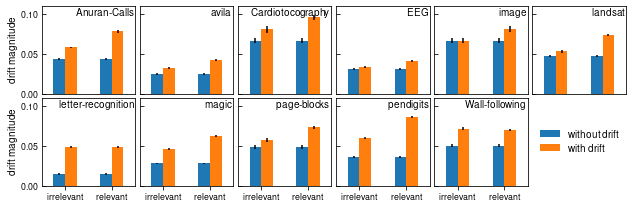

In [10]:
dm = plot_drift_magnitude(df_meta, selected_datasets)

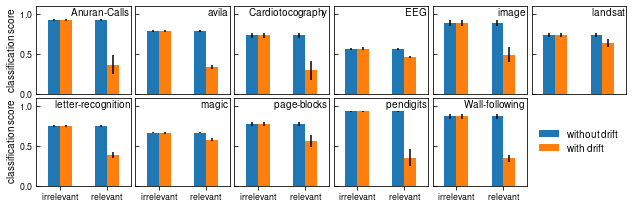

In [11]:
ie = plot_induction_effect(df_meta, selected_datasets)

In [12]:
dfs = []
for dataset in selected_datasets:
    path = os.path.join(INTERIM_DATA_DIR, dataset + '_' + BASE_DATA_TYPE + '.csv')
    df = pd.read_csv(path)
    class_ratio = (df['label'].value_counts() / len(df['label'])) * 100
    class_ratio = '%.1f%% : %.1f%%'%(class_ratio[0], class_ratio[1])
    dfs.append([dataset, df.shape[0], df.shape[1]-1, class_ratio])
df = pd.DataFrame(dfs, columns=['Dataset', '# of instances', '# of features', 'Class ratio'])

drift_magnitude = dm['with drift']['relevant'] - dm['without drift']['relevant']
change_in_score = ie['with drift']['relevant'] - ie['without drift']['relevant']

df['drift_magnitude'] = drift_magnitude[selected_datasets].values.round(3)
df['change_in_score'] = change_in_score[selected_datasets].values.round(3)

df = df.set_index('Dataset')
df

,# of instances,# of features,Class ratio,drift_magnitude,change_in_score
Dataset,,,,,
Anuran_Calls,7195,22,61.4% : 38.6%,0.035,-0.563
avila,20867,10,78.3% : 21.7%,0.018,-0.450
Cardiotocography,2126,21,77.8% : 22.2%,0.029,-0.441
EEG,14980,14,55.1% : 44.9%,0.010,-0.106
image,2310,19,71.4% : 28.6%,0.015,-0.401
landsat,6435,36,79.3% : 20.7%,0.026,-0.103
letter-recognition,20000,16,77.8% : 22.2%,0.033,-0.365
magic,19020,10,64.8% : 35.2%,0.034,-0.088
page-blocks,5473,10,89.8% : 10.2%,0.025,-0.215
